<a href="https://colab.research.google.com/github/amsewr/planeclassification/blob/main/notebooks/train_classification_model_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data & imports

In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
!tar zxf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b dataset 

In [ ]:
%%writefile requirements.txt

pathlib==1.0.1
matplotlib==3.5.0
numpy==1.21.5
pandas==1.3.5
tensorflow==2.8.0
keras==2.8.0
sklearn
pickle 

In [ ]:
!pip install -r requirements.txt

In [ ]:
import pathlib 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf
import yaml

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from PIL import Image
from yaml.loader import SafeLoader

# Constantes

In [ ]:
%%writefile launch.yaml

---
DATA_DIR: dataset/data
MODEL_DIR: model/planes
TARGET_NAME : variant

IMAGE_WIDTH: 128
IMAGE_HEIGHT: 128
IMAGE_DEPTH: 3

Overwriting launch.yaml


In [ ]:
with open('launch.yaml') as f:
  data = yaml.load(f, Loader=SafeLoader)
  print(data)

{'DATA_DIR': 'dataset/data', 'MODEL_DIR': 'model/planes', 'TARGET_NAME': 'variant', 'IMAGE_WIDTH': 128, 'IMAGE_HEIGHT': 128, 'IMAGE_DEPTH': 3}


In [ ]:
DATA_DIR = pathlib.Path(data['DATA_DIR'])
MODEL_DIR = pathlib.Path(data['MODEL_DIR'])
TARGET_NAME = data['TARGET_NAME']
IMAGE_WIDTH = data['IMAGE_WIDTH']
IMAGE_HEIGHT = data['IMAGE_HEIGHT']
IMAGE_DEPTH = data['IMAGE_DEPTH']

# Functions

In [ ]:
def build_image_database(path, target) :
  """Build a pandas dataframe with target class and access path to images.

  Parameters
  ----------
  path (Path) : path pattern to read csv file containing images information. 
  target (str) : name of the target column.

  Returns 
  -------
  A pandas dataframe, including target class and path to image.
  """

  _df =pd.read_csv(path, sep='\t'
                , names=['all']
                , dtype ={'all':str} # id are string not int
                )

  #split donne une chaine de caractères
  _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

  #'<car>'.join(liste) concatène les éléments de la liste avec le séparateur '<car>'
  _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  # La colonne path contient le chemin d'accès à l'image
  _df['path'] = _df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x +'.jpg'))

  return _df.drop(columns=['all'])

In [ ]:
manufacturer_df = build_image_database(DATA_DIR / 'images_{}_train.txt'.format(TARGET_NAME), TARGET_NAME)

In [ ]:
# La fonction :
# - prend un df (argument) 
# - prend une ligne (row : argument, l'indice de la ligne)
# - prend une colonne (target : argument)
# - elle affiche la classe (valeur de target) et l'image associée, pour la ligne en argument

def show_image(df, row, target) : 
  """Show an image from an image database, with the associated class

  Parameters
  -----------
  df(pd.DataFrame) : images definition dataframe
  row (int) :  row index in df of image to be displayed
  target (str) : name of the target column

  Returns
  ---------
  None
  """
  assert target in df.columns, "Missing target column in dataframe"
  assert 'path' in df.columns, "Missing image path in dataframe"
  print(df.iloc[row,][target])
  plt.imshow(plt.imread(df.iloc[row,]['path']))

  return

C-130


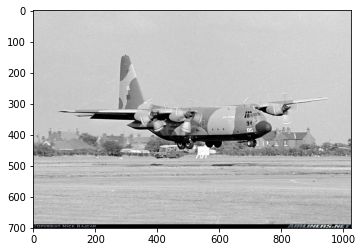

In [ ]:
show_image(manufacturer_df, 1430, TARGET_NAME)

# Verify data

In [ ]:
manufacturer_df[TARGET_NAME].value_counts(dropna=False)

707-320        34
Dornier 328    34
A380           34
An-12          34
BAE-125        34
               ..
DHC-6          33
757-200        33
DHC-8-300      33
DR-400         33
Cessna 560     33
Name: variant, Length: 100, dtype: int64

In [ ]:
assert manufacturer_df['image_id'].isna().sum() == 0, "Missing values in image_id"
assert manufacturer_df[TARGET_NAME].isna().sum() == 0, "Missing values in manufcaturer"

# Tenserflow

In [ ]:
manufacturer_df.shape

(3334, 3)

In [ ]:
manufacturer_df.head()

,image_id,variant,path
0,1025794,707-320,dataset/data/images/1025794.jpg
1,1340192,707-320,dataset/data/images/1340192.jpg
2,0056978,707-320,dataset/data/images/0056978.jpg
3,0698580,707-320,dataset/data/images/0698580.jpg
4,0450014,707-320,dataset/data/images/0450014.jpg


707-320


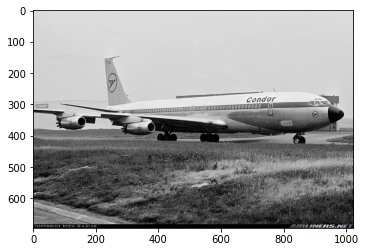

In [ ]:
show_image(manufacturer_df, 0, TARGET_NAME)

In [ ]:
manufacturer_df['shape'] = manufacturer_df['path'].apply(lambda p: plt.imread(p).shape)

In [ ]:
# Distribution du nombre de colonnes
manufacturer_df['shape'].apply(lambda x: x[1]).value_counts()

1024    1399
1200     618
1000     492
1600     145
1050     105
        ... 
1375       1
993        1
941        1
1013       1
995        1
Name: shape, Length: 73, dtype: int64

In [ ]:
def load_resize_image(path, height, width):
  """Load an image and resize it to the target size.

  Parameters
  ----------
  path (Path): access path to image file
  height (int): resize image to this height
  width (int): resize image to this width
  
  Returns
  -------
  np.array containing resized image 
  option flatten to use only 2-Dimension
  """
  return np.array(Image.open(path).resize((width, height))).flatten()

In [ ]:
manufacturer_df['resized_image'] = manufacturer_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)

In [ ]:
# Calcul du nombre de classes pour dimensionner la couche de sortie
nb_classes = manufacturer_df[TARGET_NAME].nunique()
nb_classes

70

# Build train & test set

In [ ]:
def build_x_and_y(df : pd.DataFrame, target : str, images : str):
  """Build x tensor and y tensor for model fitting. 

  Parameters
  -----------
  df (pd.DataFrame) : dataframe containing images and target 
  target (str) : name of target column
  images (str) : name of images column

  Returns
  ---------
  x (np.array) : tensor for x values 
  y (np.array) : tensor for y valuess
  """

  x = np.array(df[images].to_list())
  y = df[target].astype('category').cat.codes
  return x, y

In [ ]:
# Load train & test dataset
train_df = build_image_database(DATA_DIR / 'images_{}_train.txt'.format(TARGET_NAME), TARGET_NAME)
test_df = build_image_database(DATA_DIR / 'images_{}_test.txt'.format(TARGET_NAME), TARGET_NAME)

# Load & resize images
train_df['resized_images'] = train_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)
test_df['resized_images'] = test_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)

# Build tensors for training & testing
X_train, y_train = build_x_and_y(train_df.sample(300), TARGET_NAME, 'resized_images')
X_test, y_test = build_x_and_y(test_df.sample(100), TARGET_NAME, 'resized_images')

#Build SVM model  
clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))
#model = clf.fit(X_train,y_train)

In [ ]:
# A faire une fois pour récupérer les informations sur la TPU
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.93.164.242:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.93.164.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.93.164.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
with tpu_strategy.scope():
  model = clf.fit(X_train,y_train)

In [ ]:
train_df[TARGET_NAME].astype('category').cat.categories

Index(['A300', 'A310', 'A320', 'A330', 'A340', 'A380', 'ATR-42', 'ATR-72',
       'An-12', 'BAE 146', 'BAE-125', 'Beechcraft 1900', 'Boeing 707',
       'Boeing 717', 'Boeing 727', 'Boeing 737', 'Boeing 747', 'Boeing 757',
       'Boeing 767', 'Boeing 777', 'C-130', 'C-47', 'CRJ-200', 'CRJ-700',
       'Cessna 172', 'Cessna 208', 'Cessna Citation', 'Challenger 600',
       'DC-10', 'DC-3', 'DC-6', 'DC-8', 'DC-9', 'DH-82', 'DHC-1', 'DHC-6',
       'DR-400', 'Dash 8', 'Dornier 328', 'EMB-120', 'Embraer E-Jet',
       'Embraer ERJ 145', 'Embraer Legacy 600', 'Eurofighter Typhoon', 'F-16',
       'F/A-18', 'Falcon 2000', 'Falcon 900', 'Fokker 100', 'Fokker 50',
       'Fokker 70', 'Global Express', 'Gulfstream', 'Hawk T1', 'Il-76',
       'King Air', 'L-1011', 'MD-11', 'MD-80', 'MD-90', 'Metroliner', 'PA-28',
       'SR-20', 'Saab 2000', 'Saab 340', 'Spitfire', 'Tornado', 'Tu-134',
       'Tu-154', 'Yak-42'],
      dtype='object')

In [ ]:
%%writefile cat.yaml

---
categories_family : ['A300', 'A310', 'A320', 'A330', 'A340', 'A380', 'ATR-42', 'ATR-72',
       'An-12', 'BAE 146', 'BAE-125', 'Beechcraft 1900', 'Boeing 707',
       'Boeing 717', 'Boeing 727', 'Boeing 737', 'Boeing 747', 'Boeing 757',
       'Boeing 767', 'Boeing 777', 'C-130', 'C-47', 'CRJ-200', 'CRJ-700',
       'Cessna 172', 'Cessna 208', 'Cessna Citation', 'Challenger 600',
       'DC-10', 'DC-3', 'DC-6', 'DC-8', 'DC-9', 'DH-82', 'DHC-1', 'DHC-6',
       'DR-400', 'Dash 8', 'Dornier 328', 'EMB-120', 'Embraer E-Jet',
       'Embraer ERJ 145', 'Embraer Legacy 600', 'Eurofighter Typhoon', 'F-16',
       'F/A-18', 'Falcon 2000', 'Falcon 900', 'Fokker 100', 'Fokker 50',
       'Fokker 70', 'Global Express', 'Gulfstream', 'Hawk T1', 'Il-76',
       'King Air', 'L-1011', 'MD-11', 'MD-80', 'MD-90', 'Metroliner', 'PA-28',
       'SR-20', 'Saab 2000', 'Saab 340', 'Spitfire', 'Tornado', 'Tu-134',
       'Tu-154', 'Yak-42']

categories_manufacturer : ['ATR', 'Airbus', 'Antonov', 'Beechcraft', 'Boeing',
       'Bombardier Aerospace', 'British Aerospace', 'Canadair', 'Cessna',
       'Cirrus Aircraft', 'Dassault Aviation', 'Dornier',
       'Douglas Aircraft Company', 'Embraer', 'Eurofighter', 'Fairchild',
       'Fokker', 'Gulfstream Aerospace', 'Ilyushin', 'Lockheed Corporation',
       'Lockheed Martin', 'McDonnell Douglas', 'Panavia', 'Piper', 'Robin',
       'Saab', 'Supermarine', 'Tupolev', 'Yakovlev', 'de Havilland']

Writing cat.yaml


In [ ]:
with open('cat.yaml') as f:
  data = yaml.load(f, Loader=SafeLoader)
  print(data)

In [ ]:
def classify_images(images, model,classes_names=None):
  """Classify images through a TF model.

  Parameters
  ----------
  images (np.array): set of images to classify
  model (tf.keras.Model): TF/Keras model
  classes_names : dictionary with names of classes

  Returns
  --------
  predicted classes
  """

  results = model.predict(images)
  classes = np.argmax(results, axis=0) # np.argmax is computed row by row
  if classes_names is not None:
    classes = np.array(classes_names[classes])
  return classes

In [ ]:
classify_images(X_test, model)

89

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, model.predict(X_test))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
import datetime

def save_model(model,predictor):
  """Save sklearn model.

  Model file is named model.

  Parameters
  ----------
  model (sklearn model): model to be saved
  basename: location to save model file
  """
  pickle.dump(model, open('{}_{}.sav'.format(predictor, TARGET_NAME), 'wb'))
  return

In [ ]:
save_model(model,'SVM')